In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import glob

In [2]:
print(os.listdir('/Users/manoj/desktop/cell_images/cell_images'))

['Parasitized', 'Uninfected']


In [3]:
infected = os.listdir('/Users/manoj/desktop/cell_images/cell_images/Parasitized')
uninfected = os.listdir('/Users/manoj/desktop/cell_images/cell_images/Uninfected')

In [4]:
base_dir = os.path.join('/Users/manoj/desktop/cell_images/cell_images')
infected_dir = os.path.join('/Users/manoj/desktop/cell_images/cell_images/Parasitized')
healthy_dir = os.path.join('/Users/manoj/desktop/cell_images/cell_images/Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [5]:
files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/Users/manoj/desktop/cell_images/cell_images/P...,malaria
1,/Users/manoj/desktop/cell_images/cell_images/P...,malaria
2,/Users/manoj/desktop/cell_images/cell_images/U...,healthy
3,/Users/manoj/desktop/cell_images/cell_images/U...,healthy
4,/Users/manoj/desktop/cell_images/cell_images/U...,healthy


In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [7]:
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_6: working on img num: 5000
ThreadPoolExecutor-0_10: working on img num: 10000
ThreadPoolExecutor-0_2: working on img num: 15000
ThreadPoolExecutor-0_9: working on img num: 17360
Min Dimensions: [46 46  3]
Avg Dimensions: [132.9369276  132.32279247   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 364   3]


In [8]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_2: working on img num: 5000
ThreadPoolExecutor-1_11: working on img num: 10000
ThreadPoolExecutor-1_11: working on img num: 15000
ThreadPoolExecutor-1_8: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_3: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_1: working on img num: 0
ThreadPoolExecutor-1_7: working on img num: 5000
ThreadPoolExecutor-1_9: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

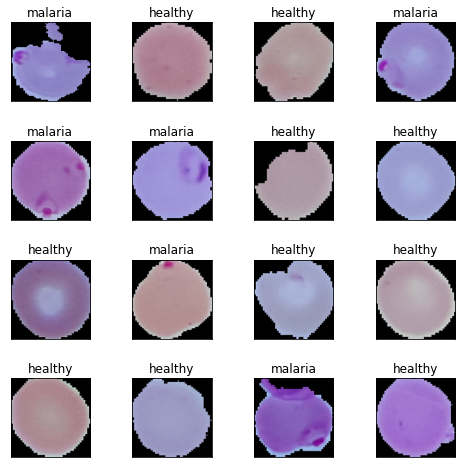

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [10]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [11]:
tf.random.set_seed(42)
tf.__version__

'2.4.1'

In [12]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [13]:
import tensorflow as tf
import datetime

In [14]:
rm -rf ./logs/

In [15]:
import datetime

logdir = os.path.join('logs/fit/', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 157s 572ms/step - loss: 0.5821 - accuracy: 0.6728 - val_loss: 0.1969 - val_accuracy: 0.9295
Epoch 2/25
272/272 [==============================] - 154s 564ms/step - loss: 0.1724 - accuracy: 0.9429 - val_loss: 0.1727 - val_accuracy: 0.9492
Epoch 3/25
272/272 [==============================] - 147s 541ms/step - loss: 0.1413 - accuracy: 0.9539 - val_loss: 0.1498 - val_accuracy: 0.9539
Epoch 4/25
272/272 [==============================] - 152s 560ms/step - loss: 0.1231 - accuracy: 0.9582 - val_loss: 0.1572 - val_accuracy: 0.9559
Epoch 5/25
272/272 [==============================] - 151s 556ms/step - loss: 0.0994 - accuracy: 0.9665 - val_loss: 0.1635 - val_accuracy: 0.9585
Epoch 6/25
272/272 [==============================] - 152s 560ms/step - loss: 0.0755 - accuracy: 0.9754 - val_loss: 0.1698 - val_accuracy: 0.9570
Epoch 7/25
272/272 [==============================] - 146s 538ms/step - loss: 0.0522 - accuracy: 0.9815 - val_loss: 0.2152 -

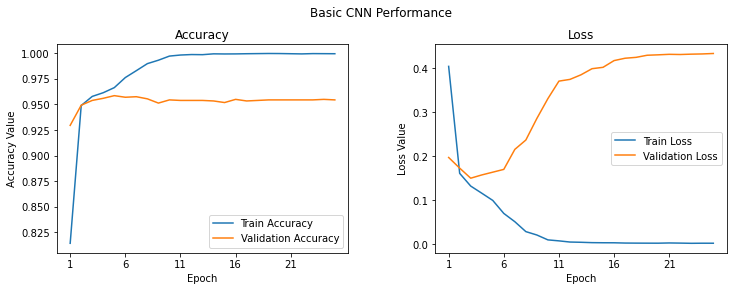

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
model.save('basic_cnn.h5')

In [18]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [19]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 788s 3s/step - loss: 0.4936 - accuracy: 0.7489 - val_loss: 0.2930 - val_accuracy: 0.8694
Epoch 2/25
272/272 [==============================] - 783s 3s/step - loss: 0.3010 - accuracy: 0.8757 - val_loss: 0.2545 - val_accuracy: 0.8958
Epoch 3/25
272/272 [==============================] - 792s 3s/step - loss: 0.2590 - accuracy: 0.8968 - val_loss: 0.3491 - val_accuracy: 0.8507
Epoch 4/25
272/272 [==============================] - 798s 3s/step - loss: 0.2502 - accuracy: 0.8967 - val_loss: 0.2101 - val_accuracy: 0.9248
Epoch 5/25
272/272 [==============================] - 790s 3s/step - loss: 0.2250 - accuracy: 0.9137 - val_loss: 0.2164 - val_accuracy: 0.9139
Epoch 6/25
272/272 [==============================] - 804s 3s/step - loss: 0.2099 - accuracy: 0.9199 - val_loss: 0.2145 - val_accuracy: 0.9150
Epoch 7/25
272/272 [==============================] - 837s 3s/step - loss: 0.1865 - accuracy: 0.9311 - val_loss: 0.1922 - val_accuracy: 0.9285

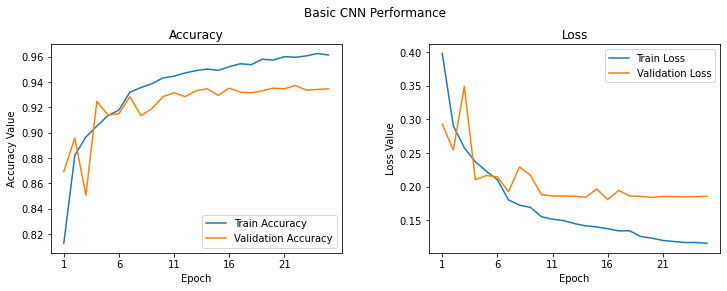

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
model.save('vgg_frozen.h5')

In [23]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


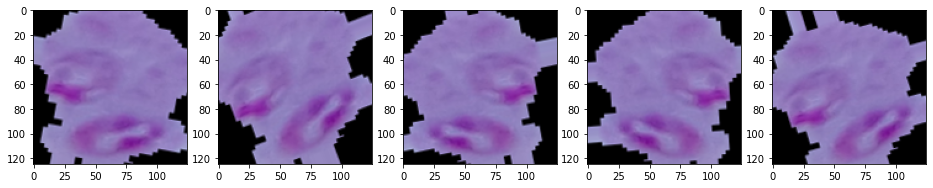

In [24]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [25]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
271/271 [==============================] - 1536s 6s/step - loss: 0.3454 - accuracy: 0.8381 - val_loss: 0.1601 - val_accuracy: 0.9484
Epoch 2/25
271/271 [==============================] - 1525s 6s/step - loss: 0.1482 - accuracy: 0.9526 - val_loss: 0.1465 - val_accuracy: 0.9536
Epoch 3/25
271/271 [==============================] - 1523s 6s/step - loss: 0.1266 - accuracy: 0.9577 - val_loss: 0.1295 - val_accuracy: 0.9583
Epoch 4/25
271/271 [==============================] - 1518s 6s/step - loss: 0.1186 - accuracy: 0.9596 - val_loss: 0.1300 - val_accuracy: 0.9620
Epoch 5/25
271/271 [==============================] - 9014s 33s/step - loss: 0.1052 - accuracy: 0.9630 - val_loss: 0.1269 - val_accuracy: 0.9557
Epoch 6/25
271/271 [==============================] - 5305s 19s/step - loss: 0.1079 - accuracy: 0.9624 - val_loss: 0.1323 - val_accuracy: 0.9578
Epoch 7/25
271/271 [==============================] - 1751s 6s/step - loss: 0.1084 - accuracy: 0.9629 - val_loss: 0.1228 - val_accurac

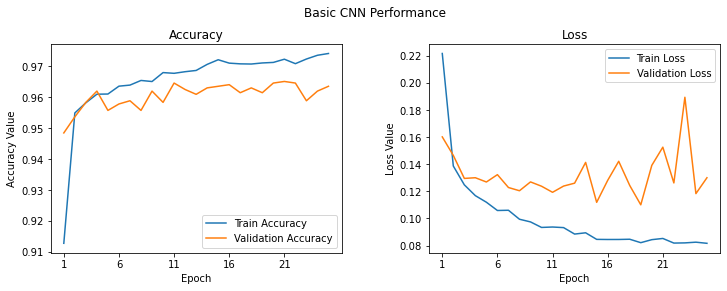

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [226]:
model.save('vgg_finetuned.h5')

In [234]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [337]:
! ls -l --block-size=MB | grep .h5

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [236]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [237]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [346]:
import new_utils as cd
import pandas as pd

In [347]:
print('Basic CNN:')
cd.display_model_performance_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels, classes=list(set(test_labels)))

Basic CNN:
Model Performance metrics:
------------------------------
Accuracy: 0.9516
Precision: 0.9517
Recall: 0.9516
F1 Score: 0.9516

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     malaria       0.96      0.94      0.95      4193
     healthy       0.94      0.96      0.95      4075

    accuracy                           0.95      8268
   macro avg       0.95      0.95      0.95      8268
weighted avg       0.95      0.95      0.95      8268


Prediction Confusion Matrix:
------------------------------


TypeError: __new__() got an unexpected keyword argument 'labels'

In [348]:
print('VGG-19 Feature Extraction:')
cd.display_model_performance_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels, classes=list(set(test_labels)))

VGG-19 Feature Extraction:
Model Performance metrics:
------------------------------
Accuracy: 0.9321
Precision: 0.9322
Recall: 0.9321
F1 Score: 0.9322

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     malaria       0.94      0.93      0.93      4193
     healthy       0.93      0.94      0.93      4075

    accuracy                           0.93      8268
   macro avg       0.93      0.93      0.93      8268
weighted avg       0.93      0.93      0.93      8268


Prediction Confusion Matrix:
------------------------------


TypeError: __new__() got an unexpected keyword argument 'labels'

In [349]:
print('VGG-19 Fine-tuned:')
cd.display_model_performance_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels, classes=list(set(test_labels)))

VGG-19 Fine-tuned:
Model Performance metrics:
------------------------------
Accuracy: 0.9653
Precision: 0.9653
Recall: 0.9653
F1 Score: 0.9653

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     malaria       0.97      0.97      0.97      4193
     healthy       0.96      0.97      0.96      4075

    accuracy                           0.97      8268
   macro avg       0.97      0.97      0.97      8268
weighted avg       0.97      0.97      0.97      8268


Prediction Confusion Matrix:
------------------------------


TypeError: __new__() got an unexpected keyword argument 'labels'